In [25]:
import numpy as np
from  scipy.optimize import curve_fit
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.linalg import logm
import random
import math
from scipy.stats import unitary_group
from scipy.optimize import minimize

In [ ]:
output_current_straight = [1.5, 2.9, 4.4, 5.9, 7.3, 8.8, 10.3, 11.7, 13.2, 14.6, 17.5, 20.3, 23.1, 25.9, 28.7, 31.4, 34.1, 36.7, 39.3, 41.9, 44.3, 46.7, 49.1, 51.5, 53.7, 55.9, 58, 60.1, 62, 63.6, 64.4, 64.4]
laser_power_straight = [393, 393, 394, 395, 396, 398, 399, 400, 402, 403, 407, 409, 411, 411, 413, 412, 408, 399, 385, 370, 354, 334, 307, 281, 250, 209, 168, 127, 88, 60, 47, 47]

In [ ]:
laser_power_straight = [x/max(laser_power_straight) for x in laser_power_straight]

In [ ]:
plt.plot(output_current_straight, laser_power_straight)
plt.title('System response on direct heating')
plt.xlabel('Output current, mA')
plt.ylabel('Output light power, units')

In [ ]:
def phase_function(x, k0, k1, k2):
    return k0+k1*x**k2

def output_function(x, k0, k1, k2):
    return (1+np.cos(phase_function(x, k0, k1, k2)))/2

initial_guess = [0.1,0.1, 0.1]
params, covariance = curve_fit(output_function, output_current_straight, laser_power_straight, p0=initial_guess)

k0_fit, k1_fit, k2_fit = params
plt.scatter(output_current_straight, laser_power_straight, color='red', label='initial data')
plt.plot(output_current_straight, output_function(output_current_straight, k0_fit, k1_fit, k2_fit), label='fitted curve')

plt.xlabel("current, mA")
plt.ylabel(r"$|A_{out}|^2$")

plt.legend()

print(k0_fit, k1_fit, k2_fit)


In [ ]:
def create_un_mat(v):
    Mc = np.zeros((2, 2),dtype=np.complex128)
    Mc[0][1] = v[0] + 1j * v[1]
    Mc[1][0] = v[0] - 1j * v[1]

    U = expm(1j * Mc)
    
    return U

def f(v, data):
    M1 = create_un_mat(v[:2])
    M2 = create_un_mat(v[2:4])
    alpha = v[4]
    h_0 = v[5]
    cost = 0
    for i in data:
        x = np.zeros(2)
        x[0] = 1000000 * i[0] ** v[6]
        y = i[1]
        y /= np.sum(y)
        h = h_0 + alpha*x[0]
        H = np.diag([math.e ** (1j * h)] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)
        cost += np.linalg.norm(np.array(predict)[0] - y)
    return cost

# def output_func(x_data, v):
#     M1 = create_un_mat(v[:2])
#     M2 = create_un_mat(v[2:4])
#     alpha=v[4]
#     h_0=v[5]
#     i=x_data
#     x = np.zeros(2)
#     x[0] = i ** 2
#     h = h_0 + alpha*x[0]
#     H = np.diag([math.e ** (1j * h)] + [1])
#     (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[0]
#     return (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[0]


def numerical_gradient(data, x, epsilon=1e-8):
    grad = np.zeros_like(x)
    f_0 = f(x, data)
    for i in range(len(x)):
        x_up = np.copy(x)
        x_down = np.copy(x)
        x_up[i] += epsilon
        x_down[i] -= epsilon
        grad[i] = (f_0 - f(x_down, data)) / (2 * epsilon)
    return np.sign(grad)


def gradient_descent(data, x0, learning_rate_start=0.01, learning_rate_finish=0.01, max_iter=1000, tol=1e-4):
    x = np.array(x0, dtype=float)
    for i in range(max_iter):
        learning_rate = (1 - i / max_iter) * learning_rate_start + learning_rate_finish
        learning_rate = learning_rate_start
        grad = numerical_gradient(data, x)
        x_new = x - learning_rate * grad
        if i % 10 == 0:
            print(x_new)
            print("Iteration = ", i, "difference = ", np.linalg.norm(x_new - x))
            print(f(x, data))
        # if f(x_new, data) - f(x, data) < tol:
        #     print(f"Сходимость достигнута за {i+1} итераций.")
        #     break
        x = x_new
    return x, f(x, data)

In [ ]:
bs=create_un_mat2([0,1/np.sqrt(2), np.pi/2])
print(bs.dot(np.transpose(bs.conj())))
# print(bs*np.sqrt(2))

In [ ]:
x0 = np.ones(7)
x0[:4] = [0,1/np.sqrt(2), 0,1/np.sqrt(2)]
x0[4]=0.00011039691180985567
x0[5]=-0.40483904616527766
x0[6]=2.4364279425296935
data = zip(output_current_straight, laser_power_straight)

def output_func(x_data, *args):
    M1 = create_un_mat(args[:2])
    M2 = create_un_mat(args[2:4])
    alpha=args[4]
    h_0=args[5]
    power=args[6]
    i=x_data
    x = i ** power
    h = h_0 + alpha*x
    H = np.diag([math.e ** (1j * h)] + [1])
    return (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[0][1]

params, covariance = curve_fit(output_func, output_current_straight, laser_power_straight, p0=x0, maxfev = 10000)
# minimum_x, minimum_f = gradient_descent(data, x0, learning_rate_start=0.001, learning_rate_finish=0.002)

In [29]:
def output_func_both(x_data, *args):
    M1 = create_un_mat(args[:2])
    M2 = create_un_mat(args[2:4])
    alpha=args[4]
    h_0=args[5]
    power=args[6]
    i=x_data
    x = i ** power
    h = h_0 + alpha*x
    H = np.diag([math.e ** (1j * h)] + [1])
    return (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[0]

[-1.36860130e-02  7.38406531e-01  1.34079232e-02  7.38413411e-01
  6.28111196e-05 -3.85230891e-01  2.56748992e+00]


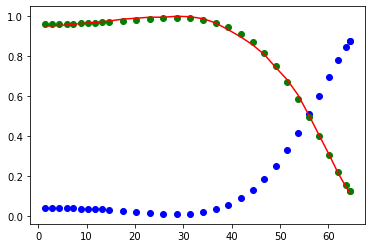

In [33]:
print(params)
# minimum_x = params
plt.plot(output_current_straight, laser_power_straight, color='red', label='initial data')
for i in output_current_straight:
    plt.scatter(i, output_func_both(i, *params)[0], color='blue')
    plt.scatter(i, output_func_both(i, *params)[1], color='green')

In [ ]:
params = np.random.random(6)
M1=create_un_mat(params[:2])
print(M1.dot(np.transpose(M1.conj())))

In [ ]:
minimum_x0 = minimum_x#np.random.random(6)
# minimum_x0[:4]=np.ones(4)
M1 = create_un_mat(minimum_x0[:2])
M2 = create_un_mat(minimum_x0[2:4])
alpha = minimum_x0[4]#0.00011039691180985567
h_0 = minimum_x0[5]#-0.40483904616527766
power = minimum_x0[6]#2.4364279425296935

for i in output_current_straight:
        x = np.zeros(2)
        x[0] = i ** power
        h = h_0 + alpha*x[0]
        H = np.diag([math.e ** (1j * h)] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[1]

        plt.scatter(i, predict[0], color = 'blue')
        plt.scatter(i, predict[1], color = 'green')

plt.plot(output_current_straight, laser_power_straight)


In [ ]:
bs = 1/np.sqrt(2)*np.array([[1,1j],[1j,1]])
print(bs)

In [ ]:
import numpy as np

# Input: A 2D array
array = np.zeros(3)
# Convert the array to a matrix
matrix = np.asmatrix(array)

# Perform matrix-specific operations
# Matrix multiplication using the `*` operator (works differently than arrays)
result = matrix * matrix.T  # Multiply the matrix with its transpose

print("Original array:")
print(array)
print("\nConverted to matrix:")
print(matrix)
print("\nMatrix multiplication result (matrix * matrix.T):")
print(result)


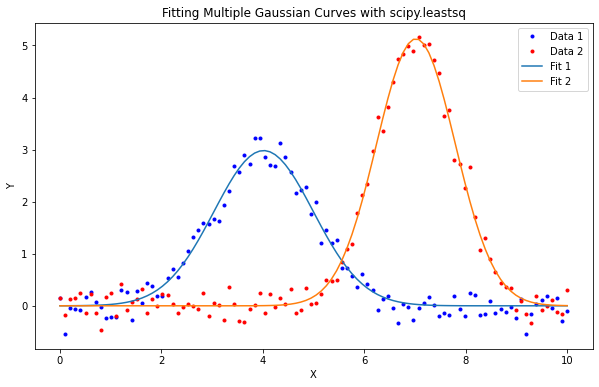

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

# Generate synthetic data for two Gaussian curves
def gaussian(x, amp, mean, std):
    return amp * np.exp(-0.5 * ((x - mean) / std)**2)

x = np.linspace(0, 10, 100)

# True parameters for two datasets
params_true = [
    (3, 4, 1),  # Dataset 1: amplitude, mean, std
    (5, 7, 0.8) # Dataset 2: amplitude, mean, std
]

y1 = gaussian(x, *params_true[0]) + np.random.normal(0, 0.2, len(x))
y2 = gaussian(x, *params_true[1]) + np.random.normal(0, 0.2, len(x))

# Combine datasets
data = [y1, y2]

# Define residual function for leastsq
def residuals(params, x, data):
    n_datasets = len(data)
    n_params = len(params) // n_datasets
    residuals = []
    for i in range(n_datasets):
        amp, mean, std = params[i*n_params:(i+1)*n_params]
        model = gaussian(x, amp, mean, std)
        residuals.extend(data[i] - model)
    return residuals

# Initial guesses for parameters
initial_guess = [2, 3, 1,  # Initial guess for dataset 1
                 4, 6, 1]  # Initial guess for dataset 2

# Perform the fit
result, _ = leastsq(residuals, initial_guess, args=(x, data))

# Extract fitted parameters
fit_params = np.reshape(result, (2, 3))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y1, 'b.', label="Data 1")
plt.plot(x, y2, 'r.', label="Data 2")

for i, (amp, mean, std) in enumerate(fit_params):
    plt.plot(x, gaussian(x, amp, mean, std), label=f"Fit {i+1}")

plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Fitting Multiple Gaussian Curves with scipy.leastsq")
plt.show()
